In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}  # string to index
stoi['.'] = 0  # add a special end-of-word character
itos = {i:s for s, i in stoi.items()}  # index to string
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
block_size = 3  # context length
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size  # start with a context of zeros
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '->', itos[ix])
        context = context[1:] + [ix]  # shift the context
X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, Y.shape)
print(X.dtype, Y.dtype)

torch.Size([228146, 3]) torch.Size([228146])
torch.int64 torch.int64


In [7]:
C = torch.randn((27, 2))  # random embedding matrix, 27 characters, 2-dimensional embeddings


In [8]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.7358, -0.4915])

In [9]:
emb = C[X]  # embed the input characters
emb.shape  # shape of the embedded input

torch.Size([228146, 3, 2])

In [10]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [11]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [12]:
h.shape

torch.Size([228146, 100])

In [13]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h @ W2 + b2  # compute the logits

In [14]:
logits.shape

torch.Size([228146, 27])

In [15]:
counts = logits.exp()  # convert logits to counts

In [16]:
prob = counts / counts.sum(1, keepdim=True)  # convert counts to probabilities
prob.shape

torch.Size([228146, 27])

In [17]:
prob[torch.arange(len(Y)), Y]  # get the probabilities of the true labels

tensor([1.5595e-07, 2.0721e-04, 1.4177e-01,  ..., 1.9965e-03, 8.2066e-08,
        6.0742e-08])

In [18]:
torch.arange(len(Y)) # shape of the indices used to index into prob

tensor([     0,      1,      2,  ..., 228143, 228144, 228145])

In [19]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [20]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [48]:
g = torch.Generator().manual_seed(1337)  # for reproducibility
C = torch.randn((27, 2), generator=g)  # random embedding matrix, 27 characters, 2-dimensional embeddings
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]  # list of all parameters

In [49]:
sum(p.nelement() for p in parameters)  # total number of parameters

3481

In [50]:
for p in parameters:
    p.requires_grad = True  # enable gradients for all parameters

![alt text](image.png)

In [51]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [54]:
lri = []
lossi = []
for i in range(1000):
    # minibatch construct

    ix = torch.randint(0, X.shape[0], (32,))  # random indices for a minibatch of size 32
    
    # forward pass
    emb = C[X[ix]] # [32, 3, 2]
     # embed the input characters
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [228146, 100] # hidden layer
    logits = h @ W2 + b2  # [228146, 27] compute the logits
    loss = F.cross_entropy(logits, Y[ix])  # compute the loss
    lossi.append(loss.item())  # store the loss for plotting
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -0.1 * p.grad  # update parameters with gradient descent

print(loss.item())  # print the loss

2.6027190685272217


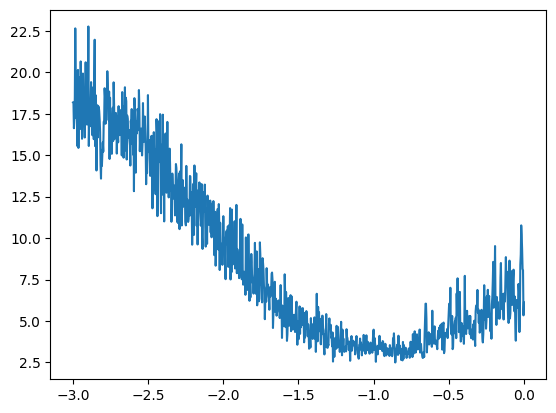

In [53]:
plt.plot(lre, lossi)

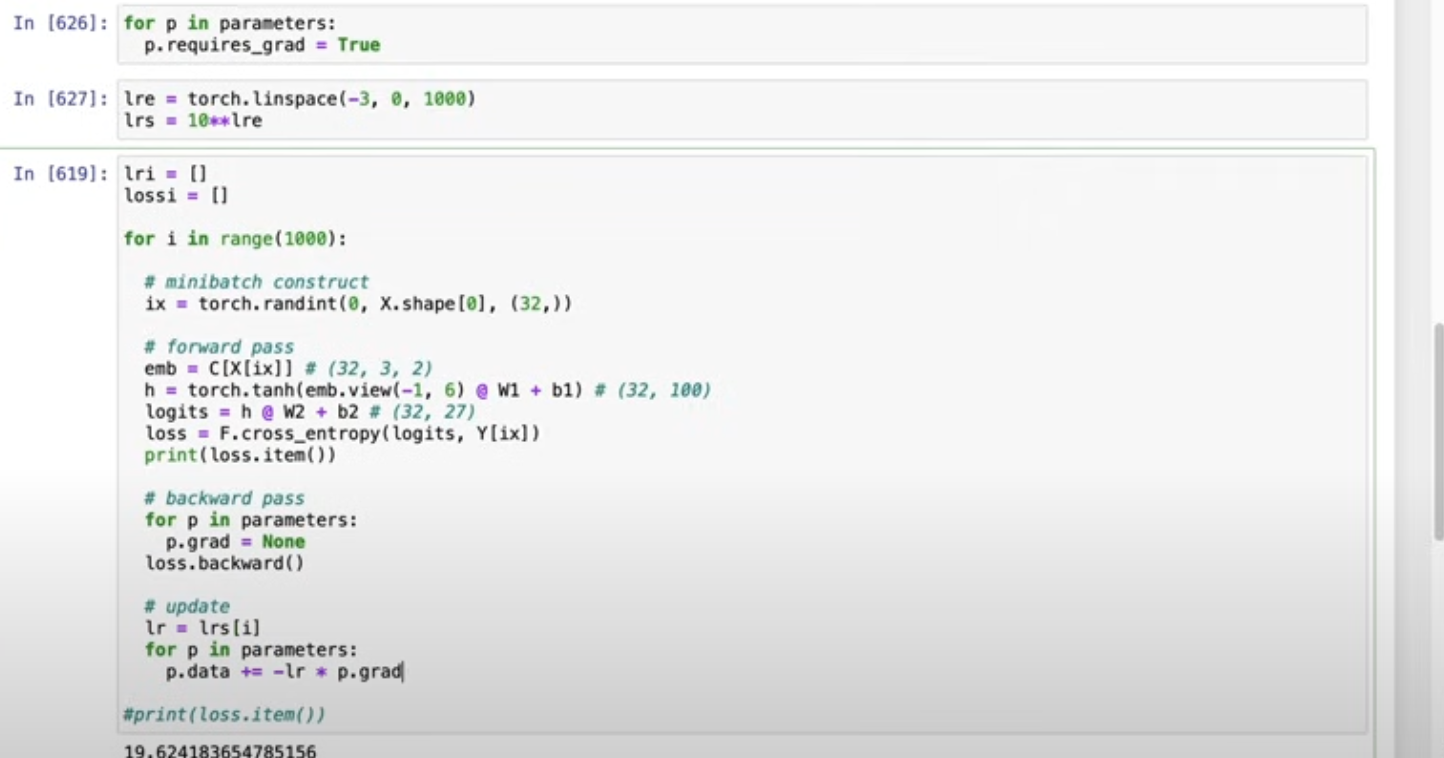

In [ ]:
g = torch.generator